# Preparation
Import the modules:

In [1]:
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

Initial parameters:

In [2]:
qty_datasets = 21
MAX_HEIGHT = 13
MAX_ITERATIONS = 100

Function for reading from a file:

In [3]:
def read_csv(datasets_path, qty_datasets):
    x_test, y_test, x_train, y_train = [], [], [], []
    for i in range(1, qty_datasets + 1):
        num = str(i) if i >= 10 else ('0' + str(i))

        test_dataset = pd.read_csv(datasets_path + '/' + num + '_test.csv')
        x_test.append(test_dataset.iloc[:, :-1].values)
        y_test.append(test_dataset.iloc[:, -1:].values)

        train_dataset = pd.read_csv(datasets_path + '/' + num + '_train.csv')
        x_train.append(train_dataset.iloc[:, :-1].values)
        y_train.append(train_dataset.iloc[:, -1:].values)
    return np.array(x_test), np.array(y_test), np.array(x_train), np.array(y_train)

# Analysis for decision tree
Find the best combination of hyperparameters:

In [4]:
def cross_validation(x_test, y_test, x_train, y_train, estimator, param_grid, verbose=0, scoring='accuracy',
                     parallel=-1):
    x = np.concatenate((x_train, x_test))
    y = np.concatenate((y_train, y_test))
    x_len = len(x_train)
    x_y_indexes = [(list(range(0, x_len)), list(range(x_len, x_len + len(x_test))))]
    return GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring=scoring,
        n_jobs=parallel,
        cv=x_y_indexes,
        verbose=verbose,
        return_train_score=True
    ).fit(x, y)

def find_best(x_test, y_test, x_train, y_train, ind=-1):
    heights = range(1, MAX_HEIGHT)
    param_grid = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': list(heights)}
    cv_results = cross_validation(x_test, y_test, x_train, y_train, DecisionTreeClassifier(), param_grid)

    best_index = cv_results.best_index_
    all_params = cv_results.cv_results_['params']
    all_test_scores = cv_results.cv_results_['split0_test_score']
    all_train_scores = cv_results.cv_results_['split0_train_score']
    params = copy.copy(cv_results.best_params_)
    if ind > -1:
        print('Best scores and param for dataset №' + str(ind + 1) +
              ': test score=' + str(all_test_scores[best_index]) + ',\t' +
              'train score=' + str(all_train_scores[best_index]) + ',\t' +
              'max_depth=' + str(params['max_depth']) + '.')
    test_scores, train_scores = [], []
    for height in heights:
        params['max_depth'] = height
        index = all_params.index(params)
        test_scores.append(all_test_scores[index])
        train_scores.append(all_train_scores[index])
    return cv_results.best_params_, test_scores, train_scores

Function that implements the decision tree:

In [5]:
def dt(x_test, y_test, x_train, y_train):
    min_tree, max_tree = None, None
    mm_indexes = (0, 0)
    for i in range(qty_datasets):
        tree = find_best(x_test[i], y_test[i], x_train[i], y_train[i], i)
        if i == 0:
            min_tree = tree
            max_tree = tree
        else:
            min_depth, depth, max_depth = min_tree[0]['max_depth'], tree[0]['max_depth'], max_tree[0]['max_depth']
            if depth < min_depth or (depth == min_depth and tree[1][depth - 1] < min_tree[1][depth - 1]):
                min_tree = tree
                mm_indexes = (i, mm_indexes[1])
            if depth > max_depth or (depth == max_depth and tree[1][depth - 1] > max_tree[1][depth - 1]):
                max_tree = tree
                mm_indexes = (mm_indexes[0], i)
    return mm_indexes, min_tree, max_tree

For the minimum and maximum optimal height set, we plot diagrams of the classification accuracy dependence on height on the training and test set.

In [6]:
def plot_tree_iml(axs, type, indexes, tree):
    x = np.arange(1, MAX_HEIGHT)
    axs.plot(x, tree[1], '-', label='Test')
    axs.plot(x, tree[2], '--', label='Train')
    axs.set_title('Dataset №' + str(indexes[0 if type == 'minimum' else 1] + 1) +
                  ' with ' + type + ' height.\n Params: ' +
                  'criterion=' + tree[0]['criterion'] + ', ' +
                  'splitter=' + tree[0]['splitter'] + ', ' +
                  'max_depth=' + str(tree[0]['max_depth']) + '.')
    axs.set_xlabel('Height')
    axs.set_ylabel('Accuracy')
    axs.legend()
    axs.grid(True)
    
def plot_for_tree(indexes, min_tree, max_tree):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    plot_tree_iml(axs[0], 'minimum', indexes, min_tree)
    plot_tree_iml(axs[1], 'maximum', indexes, max_tree)
    fig.show()

# Analysis for decision forest
Implements the decision forest сlassifier:

In [7]:
class DecisionForestClassifier(BaseEstimator):
    def __init__(self, params=None, max_samples='sqrt', max_features='sqrt', iterations=10):
        self.trees = None
        self.features = None
        self.params = {'criterion': 'gini', 'splitter': 'best'} if params is None else params
        self.max_samples = max_samples
        self.max_features = max_features
        self.iterations = iterations

    @staticmethod
    def find_max(x):
        return x[0][np.argmax(x[1])]

    def fit(self, x, y):
        size = x.shape[1]
        qty_features = size if self.max_features == 'all' else np.math.ceil(np.math.sqrt(size))
        self.params['max_features'] = qty_features
        self.features = [np.random.choice(size, qty_features, replace=False) for _ in range(self.iterations)]
        self.trees = Parallel(n_jobs=-1)(delayed(self.impl_fit)(x, y, self.features[i])
                                         for i in range(self.iterations))

    def impl_fit(self, x, y, features):
        size = x.shape[0]
        shuffle = np.random.choice(size, size if self.max_samples == 'all' else np.math.ceil(np.math.sqrt(size)),
                                   replace=True)
        tree = DecisionTreeClassifier()
        tree.set_params(**self.params)
        tree.fit(x[shuffle][:, features], y[shuffle])
        return tree

    def predict(self, x):
        predicted = []
        for val in x:
            predicted.append(self.find_max(
                np.unique(np.array(
                    [self.trees[i].predict([val[self.features[i]]])[0]
                     for i in range(self.iterations)]),
                    return_counts=True)))
        return np.array(predicted)

Find the best combination of hyperparameters:

In [8]:
def print_score_forest(type, scores, params):
    max_index_test = np.argmax(scores)
    print("Best scores and param for forest on " + type + ": "
          + type + ' score=' + str(scores[max_index_test])
          + ' all_params:' + (','.join([k + '=' + str(v) for k, v in params[max_index_test].items()])))

def df(x_test, y_test, x_train, y_train, params):
    iteration = range(1, MAX_ITERATIONS)
    params.pop('max_depth')
    signs = ['all', 'sqrt']
    param_grid = {'params': [params], 'max_samples': signs, 'max_features': signs, 'iterations': list(iteration)}
    cv_results = cross_validation(x_test, y_test, x_train, y_train, DecisionForestClassifier(), param_grid)
    test_all_all, test_all_sqrt, test_sqrt_all, test_sqrt_sqrt = [], [], [], []
    train_all_all, train_all_sqrt, train_sqrt_all, train_sqrt_sqrt = [], [], [], []
    all_test_scores = cv_results.cv_results_['split0_test_score']
    all_train_scores = cv_results.cv_results_['split0_train_score']

    all_params = cv_results.cv_results_['params']
    cur_params = copy.copy(cv_results.best_params_)

    for sample in signs:
        for feature in signs:
            for i in iteration:
                cur_params['iterations'] = i
                cur_params['max_samples'] = sample
                cur_params['max_features'] = feature
                index = all_params.index(cur_params)
                if sample == 'all' and feature == 'all':
                    test_all_all.append(all_test_scores[index])
                    train_all_all.append(all_train_scores[index])
                elif sample == 'all' and feature == 'sqrt':
                    test_all_sqrt.append(all_test_scores[index])
                    train_all_sqrt.append(all_train_scores[index])
                elif sample == 'sqrt' and feature == 'all':
                    test_sqrt_all.append(all_test_scores[index])
                    train_sqrt_all.append(all_train_scores[index])
                else:
                    test_sqrt_sqrt.append(all_test_scores[index])
                    train_sqrt_sqrt.append(all_train_scores[index])

    print_score_forest("test", all_test_scores, all_params)
    print_score_forest("train", all_train_scores, all_params)

    return cv_results.best_params_, [test_all_all, test_all_sqrt, test_sqrt_all, test_sqrt_sqrt], \
           [train_all_all, train_all_sqrt, train_sqrt_all, train_sqrt_sqrt]

For a set with minimum and maximum optimal height, we plot diagrams of the dependence of classification accuracy on the number of iterations on the training and test set.

In [9]:
def plot_forest_iml(axs, type, tree):
    x = np.arange(1, MAX_ITERATIONS)
    axs.plot(x, tree[0], '-', label=(type + '-all-all'))
    axs.plot(x, tree[1], '-', label=(type + '-all-sqrt'))
    axs.plot(x, tree[2], '-.', label=(type + '-sqrt-all'))
    axs.plot(x, tree[3], ':', label=(type + '-sqrt-all'))
    axs.set_title(type)
    axs.set_xlabel('Iterations')
    axs.set_ylabel('Accuracy')
    axs.legend()
    axs.grid(True)

def plot_for_forest(forest, name):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    plot_forest_iml(axs[0], 'Test', forest[1])
    plot_forest_iml(axs[1], 'Train', forest[2])
    fig.suptitle('Plots for values with ' + name + ' height')
    fig.show()

Best scores and param for dataset №1: test score=0.9997429966589566,	train score=0.9465433050629658,	max_depth=3.
Best scores and param for dataset №2: test score=0.7,	train score=0.8936386768447837,	max_depth=9.
Best scores and param for dataset №3: test score=1.0,	train score=0.9532304725168756,	max_depth=1.
Best scores and param for dataset №4: test score=0.9951304347826087,	train score=0.9610434782608696,	max_depth=5.
Best scores and param for dataset №5: test score=0.9956709956709957,	train score=0.9718614718614719,	max_depth=1.
Best scores and param for dataset №6: test score=0.9988962472406181,	train score=0.9630242825607064,	max_depth=3.
Best scores and param for dataset №7: test score=0.9967441860465116,	train score=0.9525581395348838,	max_depth=3.
Best scores and param for dataset №8: test score=0.997920997920998,	train score=0.9812889812889813,	max_depth=2.
Best scores and param for dataset №9: test score=0.8509803921568627,	train score=0.8823529411764706,	max_depth=5.
Best 

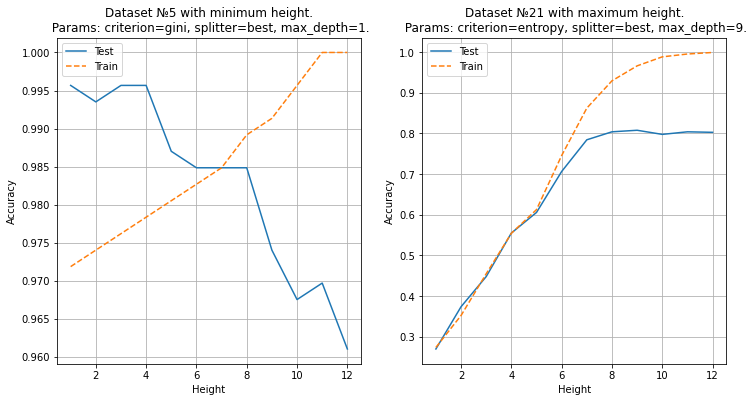

In [10]:
start_time = time.time()

x_test, y_test, x_train, y_train = read_csv('./datasets', qty_datasets)
indexes, min_tree, max_tree = dt(x_test, y_test, x_train, y_train)
plot_for_tree(indexes, min_tree, max_tree)

Min forest:
Best scores and param for forest on test: test score=1.0 all_params:iterations=18,max_features=all,max_samples=sqrt,params={'criterion': 'gini', 'splitter': 'best'}
Best scores and param for forest on train: train score=1.0 all_params:iterations=5,max_features=all,max_samples=all,params={'criterion': 'gini', 'splitter': 'best'}


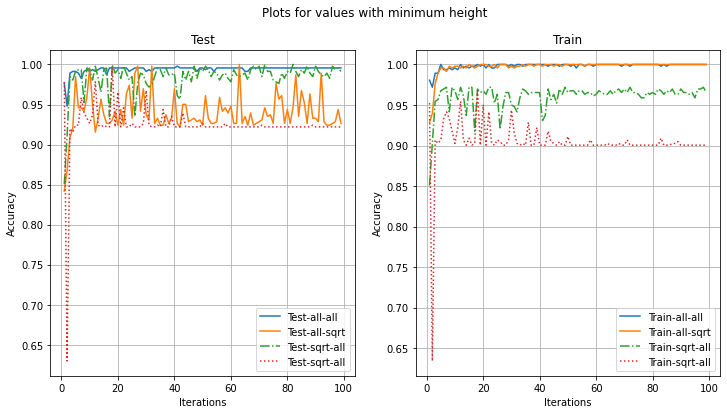

In [11]:
min_index, max_index = indexes
print("Min forest:")
min_forest = df(x_test[min_index], y_test[min_index], x_train[min_index], y_train[min_index], min_tree[0])
plot_for_forest(min_forest, 'minimum')

Max forest
Best scores and param for forest on test: test score=0.8604946100190235 all_params:iterations=58,max_features=all,max_samples=all,params={'criterion': 'entropy', 'splitter': 'best'}
Best scores and param for forest on train: train score=1.0 all_params:iterations=14,max_features=sqrt,max_samples=all,params={'criterion': 'entropy', 'splitter': 'best'}


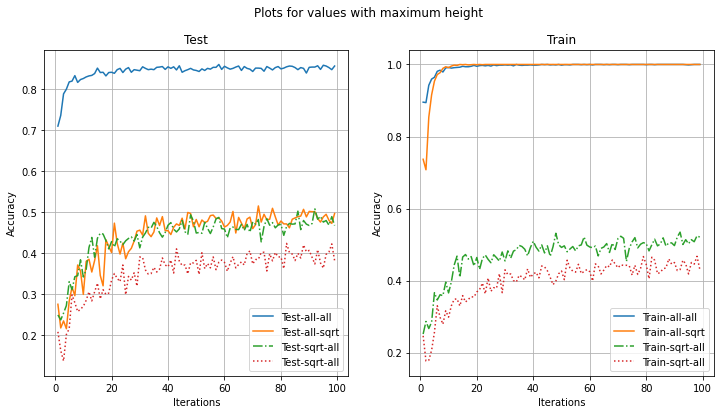

In [12]:
print("Max forest")
max_forest = df(x_test[max_index], y_test[max_index], x_train[max_index], y_train[max_index], max_tree[0])
plot_for_forest(max_forest, 'maximum')

In [13]:
print('Total working time: %s seconds.' % (time.time() - start_time))

Total working time: 2395.238652229309 seconds.
